# Distributions

*Purpose*: (We will use distributions to model uncertain quantities. Thus, this exercise covers fundamental concepts related to distributions.)


## Setup


In [1]:
import grama as gr
import numpy as np
DF = gr.Intention()
%matplotlib inline

# Motivation: Modeling Uncertainty

## To Summarize Data


In [2]:
from grama.data import df_shewhart


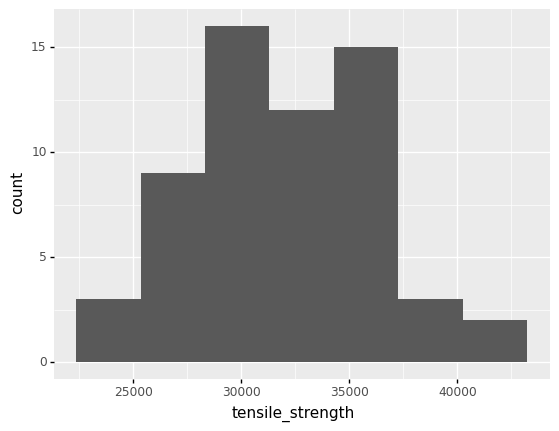

<ggplot: (8794072537396)>

In [3]:
(
    df_shewhart
    >> gr.ggplot(gr.aes("tensile_strength"))
    + gr.geom_histogram()
)

In [5]:
# Fit a lognormal distribution
mg_tensile_strength = gr.marg_fit(
    "lognorm",
    df_shewhart.tensile_strength,
    floc=0,
)
# Show a summary
mg_tensile_strength

(+0) lognorm, {'mean': '3.187e+04', 's.d.': '4.019e+03', 'COV': 0.13, 'skew.': 0.38, 'kurt.': 3.26}

Rather than using the entire dataset to describe the observed variability, we can now summarize it as a lognormal distribution with the parameters listed above.


## To Make Assumptions Explicit

For instance, are we assuming that values are strictly bounded between low and high values? Or are there no bounds? 


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


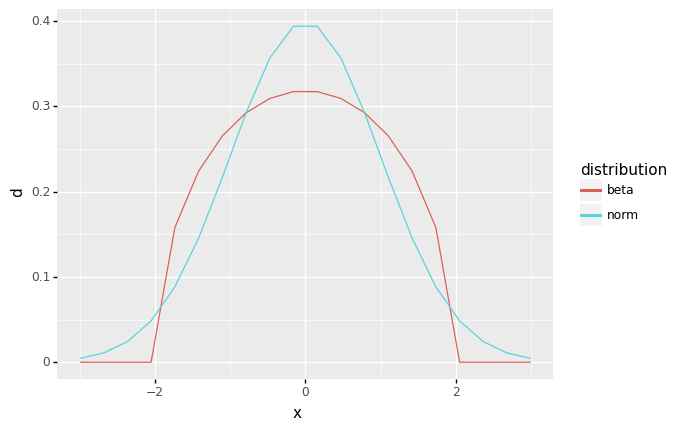

<ggplot: (8794072113523)>

In [7]:
# Normal is unbounded
mg_norm = gr.marg_mom("norm", mean=0, sd=1)
# Beta is strictly bounded
mg_beta = gr.marg_mom("beta", mean=0, sd=1, skew=0, kurt=2)

(
    gr.df_make(x=gr.linspace(-3, +3, 20))
    >> gr.tf_mutate(
        d_norm=mg_norm.d(DF.x),
        d_beta=mg_beta.d(DF.x),
    )
    >> gr.tf_pivot_longer(
        columns=["d_norm", "d_beta"],
        names_to=[".value", "distribution"],
        names_sep="_",
    )
    
    >> gr.ggplot(gr.aes("x", "d", color="distribution"))
    + gr.geom_line()
)

# Distribution Fundamentals

*Note*: In this exercise, to keep things simple, we will focus on distributions for *continuous* variable.


## What a distribution represents

*Fundamentally*, a distribution describes an uncertain value *in a quantitative fashion*. Rather than simply saying "I don't know what value this is," with a distribution we can express the fact that some values are more *likely* than others.

Distributions are particularly useful because they free us from "just" picking a single number. With a distribution we can get a lot more nuanced in our description of uncertain quantities. This exercise is all about using concepts about distributions to represent uncertain quantities, *and to do useful work*.


### __qX__ Define a distribution


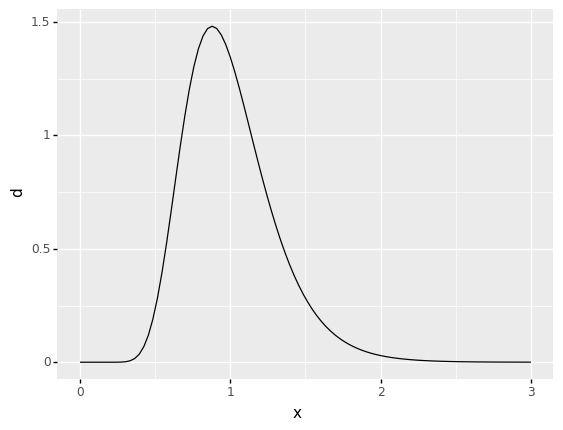

<ggplot: (8794071858887)>

In [8]:

mg_lognorm = gr.marg_mom("lognorm", mean=1, sd=0.3, floc=0)
## NOTE: No need to edit; this will plot your distribution
(
    gr.df_make(x=gr.linspace(0, 3, 100))
    >> gr.tf_mutate(d=mg_lognorm.d(DF.x))
    >> gr.ggplot(gr.aes("x", "d"))
    + gr.geom_line()
)

### __qX__ Check your distribution's summary


In [9]:
mg_lognorm
# solution-end

(+0) lognorm, {'mean': '1.000e+00', 's.d.': '3.000e-01', 'COV': 0.3, 'skew.': 0.93, 'kurt.': 4.57}

*Observations*

- What mean does your distribution have?
  - `mean = 1.0`
- What value of *skewness* does your distribution have?
  - `skewness = 0.93`
- What value of *kurtosis* does your distribution have?
  - `kurtosis = 4.57`
<!-- solution-end -->

### __qX__ *Draw* random values from your distribution

Use the `mg.r(n)` method to *draw* random values from your distribution. Play with the sample size `n`, and answer the questions under *observations* below.


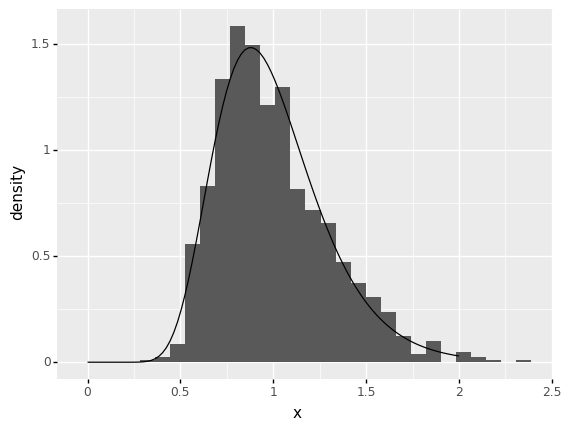

<ggplot: (8794071620849)>

In [12]:


X = mg_lognorm.r(1000)
## NOTE: No need to edit; use this to check your answer
(
    gr.df_make(x=X)
    >> gr.ggplot(gr.aes("x"))
    + gr.geom_histogram(bins=30, mapping=gr.aes(y="stat(density)"))
    + gr.geom_line(
        data=gr.df_make(x=gr.linspace(0, 2, 100))
        >> gr.tf_mutate(d=mg_lognorm.d(DF.x)),
        mapping=gr.aes(y="d")
    )
)

*Observations*



## Mean (aka Expectation)

$$\overline{X} = \frac{1}{n} \sum_{i=1}^n X_i$$

$$\mathbb{E}[X] = \lim_{n\to\infty} \frac{1}{n} \sum_{i=1}^n X_i$$


### __qX__ Estimate a (sample) mean


In [15]:
(
    gr.df_make(x=mg_lognorm.r(100))
    >> gr.tf_summarize(
        x_mean=gr.mean(DF.x)
    )
)

,x_mean
0,1.021326


*Observations*

- How does the sample mean compare with the true mean of your distribution `mg_lognorm`?
  - The value is different each time, but I get a value quite close to `1.0`, the true mean.
- What might account for this difference?
  - We took a limited sample $n < \infty$, thus there is sampling error in the estimated mean.
- Re-run the cell; do you get an identical value?
  - Nope! There is randomness in the estimate.
<!-- solution-end -->

## Probability

Probability is the area under the curve, within a set of interest. For instance, if we were interested in the probability that $0.5 <= X <= 0.7$, the following area would be the probability:


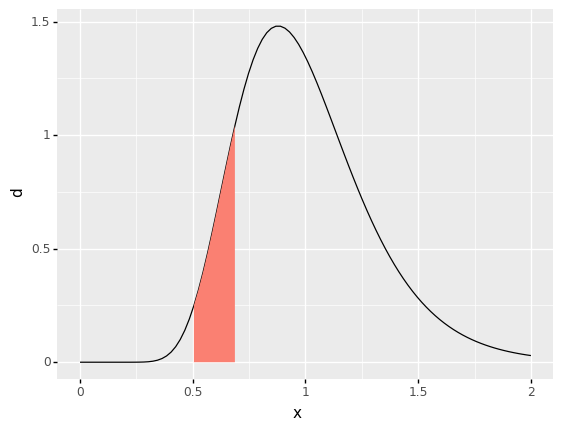

<ggplot: (8794071725180)>

In [22]:
df_tmp = (
    gr.df_make(x=gr.linspace(0, 2, 100))
    >> gr.tf_mutate(d=mg_lognorm.d(DF.x))
)

(
    df_tmp
    >> gr.ggplot(gr.aes("x", "d"))
    + gr.geom_line()
    + gr.geom_ribbon(
        data=df_tmp
        >> gr.tf_filter(0.5 <= DF.x, DF.x <= 0.7),
        mapping=gr.aes(ymin=0, ymax="d"),
        fill="salmon",
        color=None,
    )
)

Note that probability is associated with a *set*---a range of values---not just a single value. Note that the area under the curve for a single value would have zero width, hence zero probability!


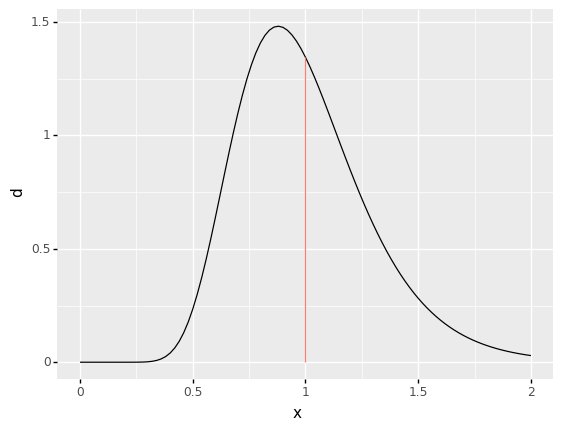

<ggplot: (8794043437406)>

In [23]:
df_tmp = (
    gr.df_make(x=gr.linspace(0, 2, 101))
    >> gr.tf_mutate(d=mg_lognorm.d(DF.x))
)

(
    df_tmp
    >> gr.ggplot(gr.aes("x", "d"))
    + gr.geom_line()
    + gr.geom_segment(
        data=df_tmp
        >> gr.tf_filter(DF.x == gr.median(DF.x)),
        mapping=gr.aes(xend="x", yend=0),
        color="salmon",
    )
)

A more mathematical definition for probability is in terms of the expectation

$$\mathbb{P}[X \in A] = \mathbb{E}[1(X \in A)]$$

where $1(X \in A)$ is the *indicator function*, which is just a fancy way of tracking whether or not a point lands in the set $A$. The function takes values $1,0$ depending on whether or not a value $X$ lands inside the set $A$.

$$1(X \in A) = \left\{\begin{array}{cc} 1 & \text{ if }X \in A \\ 0 & \text{ otherwise}\end{array}\right.$$

This expectation definition is not just math for its own sake; this expectation of the indicator definition is **easy to translate into computer code**.


### __qX__ Compute an indicator


In [29]:


df_ind = (
    gr.df_make(x=mg_lognorm.r(100))

    >> gr.tf_mutate(
        ind=DF.x <= 1,
    )
)

# NOTE: No need to edit; use this to check your work
assert \
    "ind" in df_ind.columns, \
    "The result df_ind does not have an indicator column `ind`"

assert \
    (all(df_ind.ind == (df_ind.x <= 1))), \
    "Your indicator column `ind` is incorrect."

### __qX__ Estimate a probability


In [30]:
(
    df_ind
    >> gr.tf_summarize(pr=gr.mean(DF.ind))
)

,pr
0,0.56


### __qX__ Estimate a probability of failure


## Quantiles

Quantiles "turn around" the idea of probability. With probability we start with a set $A$ and arrive at a probability value $p$. With a *quantile* we start with a probability value $p$ and arrive at a single value $q$.


### __qX__ Compute a quantile


In [36]:

q_10 = mg_lognorm.q(0.10)
q_50 = mg_lognorm.q(0.50)
# NOTE: No need to edit; use this to check your work
(
    gr.df_make(x=mg_lognorm.r(1000))
    >> gr.tf_summarize(
        pr_10=gr.mean(DF.x <= q_10), # Should be around 0.10
        pr_50=gr.mean(DF.x <= q_50), # Should be around 0.50
    )
)

,pr_10,pr_50
0,0.105,0.498


### __qX__ Estimate a conservative strength


In [34]:
(
    df_shewhart 
    >> gr.tf_summarize(
        lower=gr.quant(DF.tensile_strength, 0.10),
        mean=gr.mean(DF.tensile_strength),
    )
)

,lower,mean
0,26395.0,31869.366667


*Observations*

- Suppose the observed variability in the `tensile_strength` is real. Which of `mean` or `lower` is safer to use for design purposes? Why?
  - If the variability is real, then `lower` is definitely safer for design. Real variability means that parts can end up with a strength lower than the `mean`; thus if we design assuming the `mean` value, real parts may end up failing.
